# Try to add a nifty model for sampling the input map

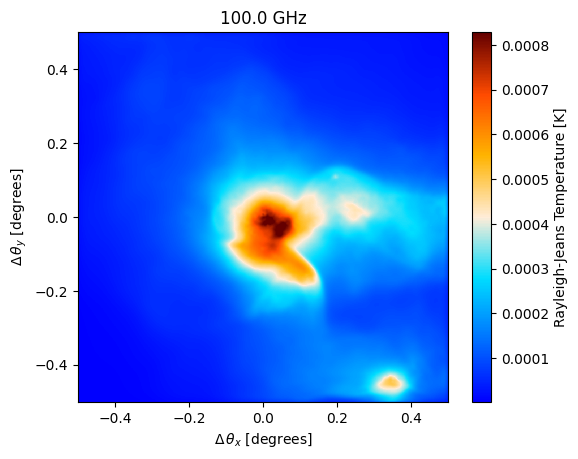

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/big_cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename,
                                width=1., #degrees
                                index=1,
                                center=(300.0, -10.0), #RA and Dec in degrees
                                units ='Jy/pixel'
                               )

input_map.to(units="K_RJ").plot()

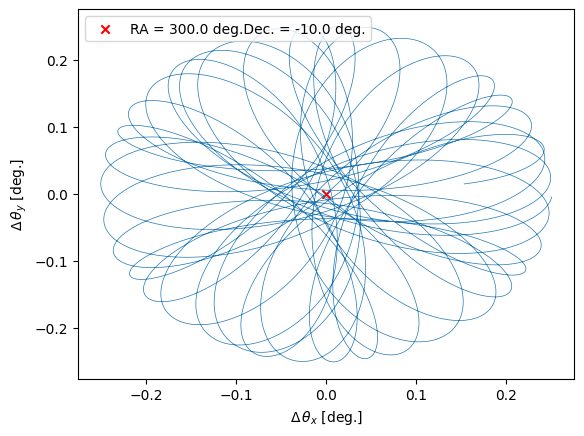

In [2]:
plan = maria.get_plan(scan_pattern="daisy",
                      scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
                      duration=60, # in seconds
                      sample_rate=225, # in Hz
                      start_time = "2022-08-10T06:00:00",
                      scan_center=(300.0, -10.0),
                      frame="ra_dec")
plan.plot()

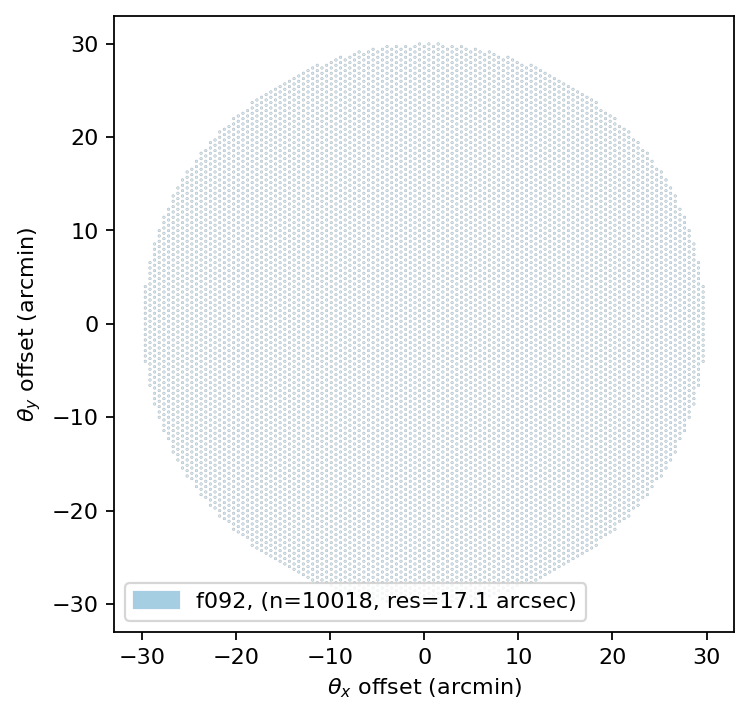

In [3]:
from maria.instrument import Band

f090 = Band(center=92, # in GHz
            width=40.0,
            knee=1,
            sensitivity=6e-5) # in K sqrt(s)

array = {"field_of_view": 1.0, "bands": [f090]}
instrument = maria.get_instrument(array=array, primary_size=50, beam_spacing = 2)
instrument.plot()

In [4]:
sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                # atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

2024-09-19 13:52:22.904 INFO: Constructed instrument.
2024-09-19 13:52:22.905 INFO: Constructed plan.
2024-09-19 13:52:22.905 INFO: Constructed site.
2024-09-19 13:52:23.572 INFO: Constructed boresight.
2024-09-19 13:52:29.422 INFO: Constructed offsets.


Initialized base in 6519 ms.


Sampling map (f092): 100%|██████████| 1/1 [01:06<00:00, 66.01s/it]


In [5]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

In [6]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(300.0, -10.0),
                   frame="ra_dec",
                   width=1.,
                   height=1.,
                   resolution=np.degrees(np.nanmin(instrument.fwhm))/4.,
                #    tod_postprocessing={
                #         "window": {"tukey": {"alpha": 0.1}},
                #         "remove_modes": {"n": 1},
                #         "highpass": {"f": 0.05},
                #         "despline": {"spacing": 10},
                #     },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 0},
                        # "gaussian_filter": {"sigma": 1},
                        # "median_filter": {"size": 1},
                    },
                  )

# mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

Running mapper (f092): 100%|██████████| 1/1 [02:04<00:00, 124.01s/it]

mapdata_truth shape: (1, 1024, 1024)
mapdata_truth mean: 0.00013284593853240577


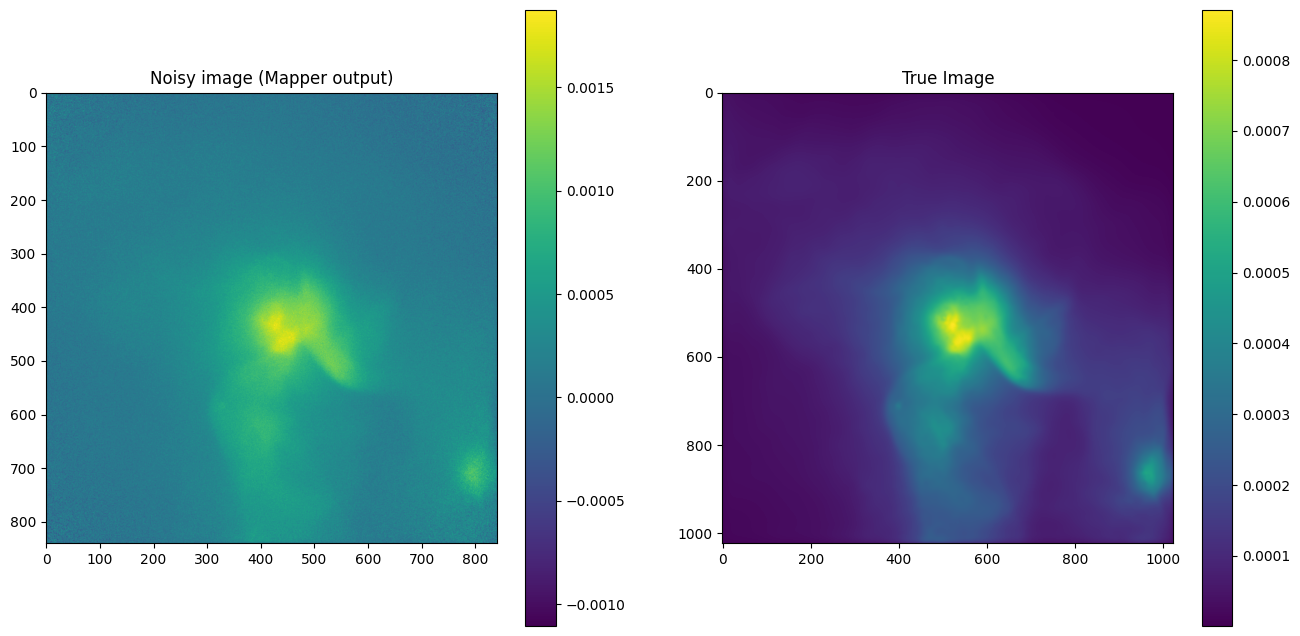

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0])
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-09-19 13:56:38.964 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-09-19 13:56:38.969 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [9]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [10]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [11]:
from maria.constants import k_B
from maria.instrument import beams

@jax.jit
def sample_maps(sim_truthmap, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            sim_truthmap,
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)


        nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        power_map = (
            1e12
            * k_B
            * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            # Need to invert x_side and y_side for jax interpolation:
            # (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
            (x_side, y_side), # length N=2 sequence of arrays with grid coords
            # jax.numpy.flip(sim_truthmap[0]),
            # jax.numpy.flip(filtered_power_map), # N=2-dimensional array specifying grid values (1000, 1000)
            filtered_power_map, # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

## Test TOD agreement for noise-free map

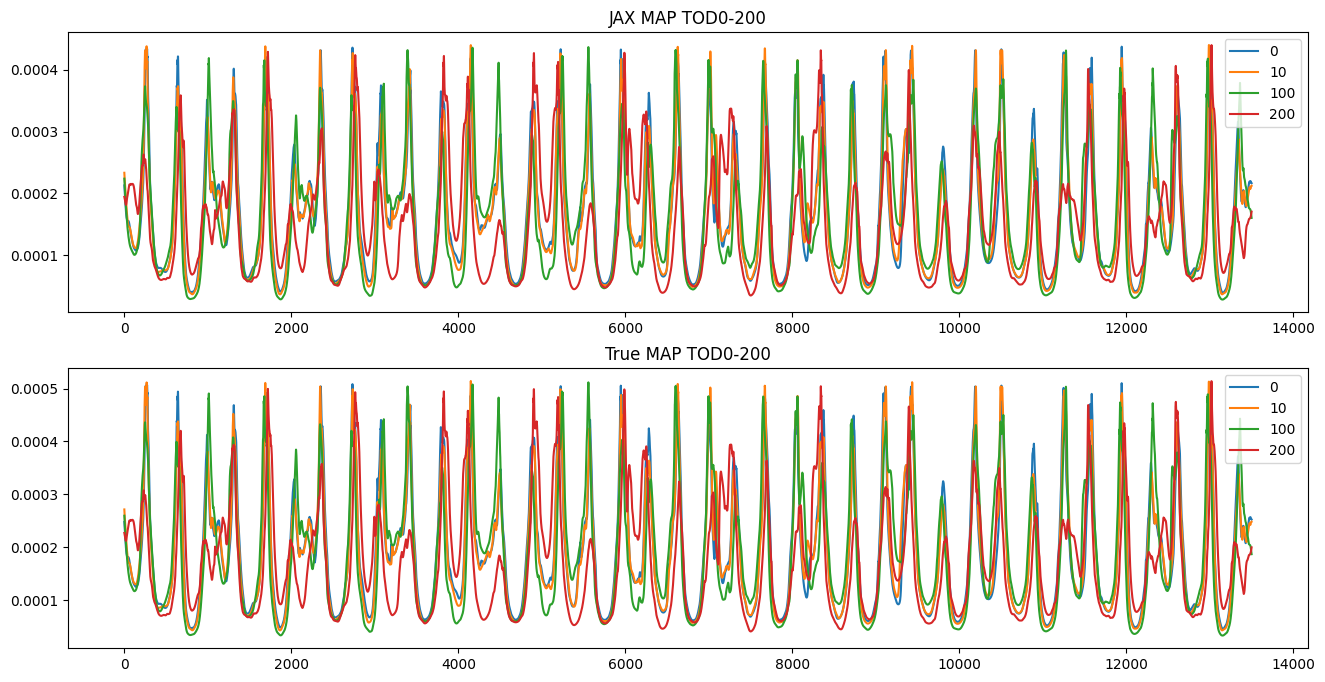

In [12]:
jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Next, initialise nifty prior model

Noise stddev: 0.00028091346


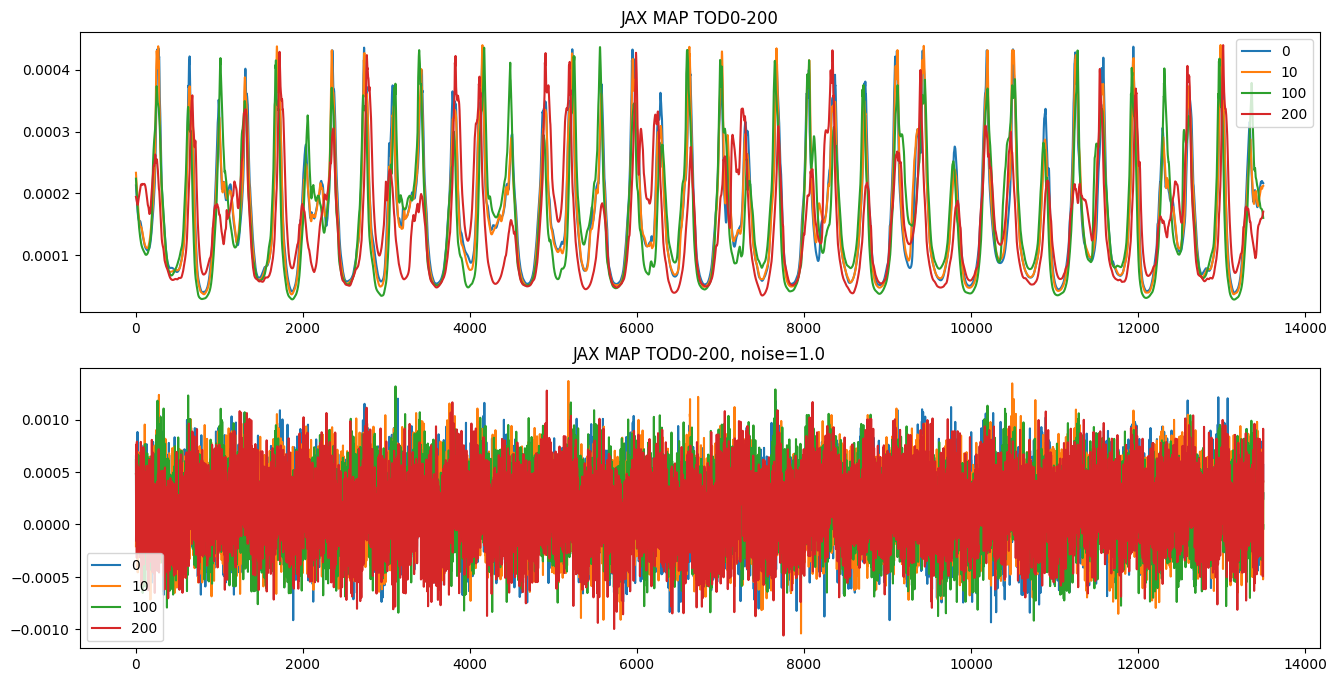

In [13]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
noised_jax_tod = jax_tods + np.float64(tod_truthmap.components['noise']*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    im1 = axes[1].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'JAX MAP TOD0-{i}, noise={noiselevel}')
axes[1].legend()

plt.show()

In [14]:
# dims = (1000, 1000)
dims = (1024, 1024)

# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
cf_zm_map = dict(offset_mean=1.3e-4, offset_std=(5e-5, 5e-5))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1e-3, 1e-4), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-3e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [15]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
noise_cov_inv_map = lambda x: 1e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
# lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
lh_tod = jft.Gaussian( noised_jax_tod, noise_cov_inv_tod).amend(signal_response_tod)
lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`
assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [16]:
key, sub = random.split(key)
print(lh_map_grad(jft.random_like(sub, lh_map.domain)))
print(lh_tod_grad(jft.random_like(sub, lh_tod.domain)))

Vector(
	{'cfmapax1fluctuations': Array(12458784.16464638, dtype=float64),
	 'cfmapax1loglogavgslope': Array(-6669999.35108106, dtype=float64),
	 'cfmapxi': Array([[  329293.03972108, 13193588.36555094,  -377334.17890795, ...,
	          250144.14668772,   -40742.50332451,  6868050.39476921],
	       [-4140893.56491896, -8761974.24555877, -1475508.86319311, ...,
	         -428813.81116975,  -542913.59818751, -3272845.8703726 ],
	       [ -642317.24887134,   136792.8368838 ,   106480.63797999, ...,
	          316996.02545145,  -529047.87684088,   771406.49353686],
	       ...,
	       [   38600.93556235,    78213.97580962,  -347148.17290396, ...,
	           62752.06268625,   370755.73258128,  -229196.9310817 ],
	       [ 1545104.72344187,   867917.890767  ,   407852.98553241, ...,
	          -69996.75485038,   605021.91331778,  2580341.45021828],
	       [14194044.85516432,   244730.1066295 ,   704246.80732441, ...,
	         -101679.72764135,   633576.00151197,  2400107.91330587]],   

# MAP fit

In [17]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-12
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001


M: →:1.0 ↺:False #∇²:06 |↘|:3.952188e+01 ➽:1.048579e+02
M: Iteration 1 ⛰:+9.599562e+07 Δ⛰:1.009023e+08
OPTIMIZE_KL: Iteration 0001 ⛰:+9.5996e+07
OPTIMIZE_KL: #(KL minimization steps) 1
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²:     1.4±     0.0, avg:   +0.011±     0.0, #dof:135243000'

OPTIMIZE_KL: Prior residual(s):
cfmapax1fluctuations    :: 'reduced χ²:     1.6±     0.0, avg:     -1.3±     0.0, #dof:      1'
cfmapax1loglogavgslope  :: 'reduced χ²:     2.0±     0.0, avg:     -1.4±     0.0, #dof:      1'
cfmapxi                 :: 'reduced χ²:     1.0±     0.0, avg: +0.00095±     0.0, #dof:1048576'
cfmapzeromode           :: 'reduced χ²:    0.13±     0.0, avg:    +0.36±     0.0, #dof:      1'




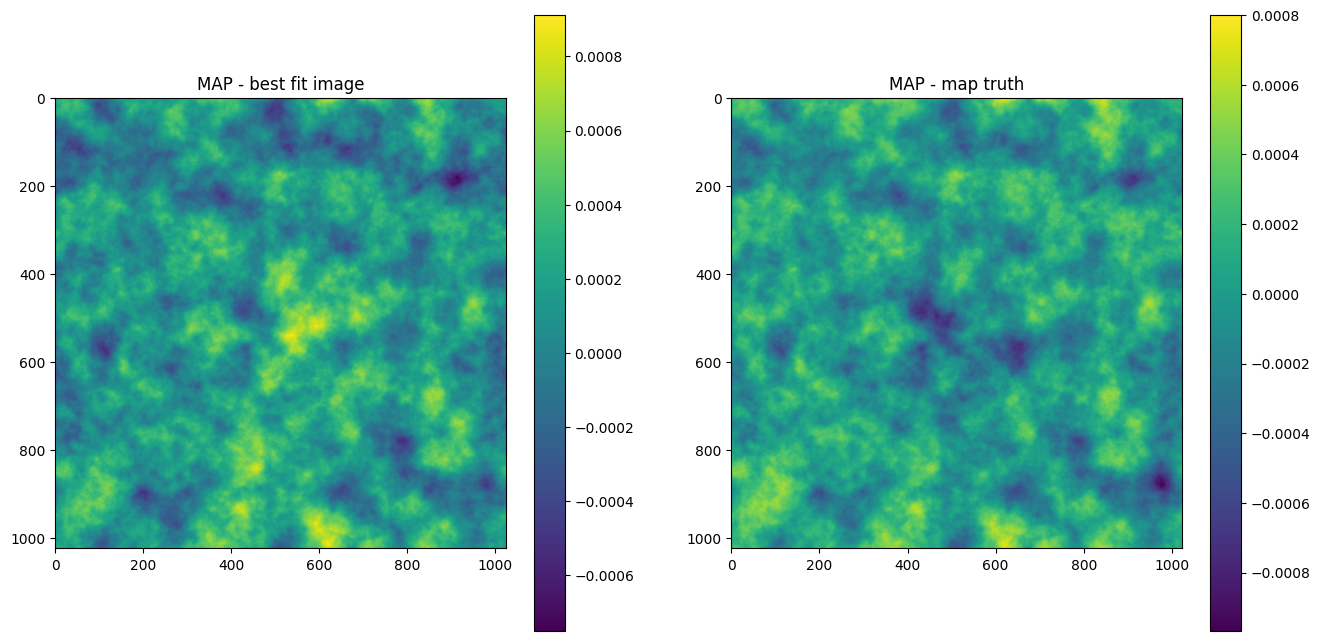

In [18]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

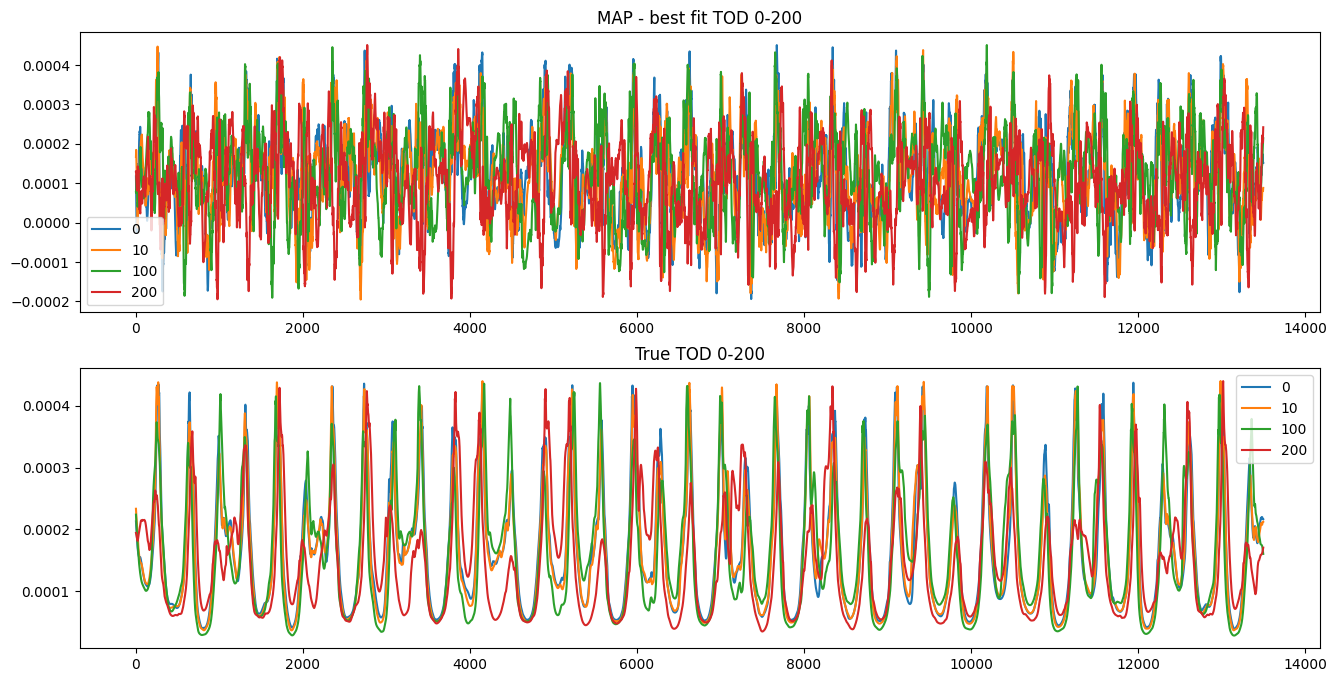

In [19]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()

plt.show()

In [20]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+2.4742e+08 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+7.4212e+07 Δ⛰:1.7321e+08 ➽:1.0486e+01
SL: Iteration 2 ⛰:+4.9820e+07 Δ⛰:2.4392e+07 ➽:1.0486e+01
SL: Iteration 3 ⛰:+3.9995e+07 Δ⛰:9.8244e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:+2.9562e+07 Δ⛰:1.0433e+07 ➽:1.0486e+01
SL: Iteration 5 ⛰:+2.7635e+07 Δ⛰:1.9272e+06 ➽:1.0486e+01
SL: Iteration 6 ⛰:+2.4431e+07 Δ⛰:3.2044e+06 ➽:1.0486e+01
SL: Iteration 7 ⛰:+2.1021e+07 Δ⛰:3.4094e+06 ➽:1.0486e+01
SL: Iteration 8 ⛰:+2.0020e+07 Δ⛰:1.0013e+06 ➽:1.0486e+01
SL: Iteration 9 ⛰:+1.7679e+07 Δ⛰:2.3405e+06 ➽:1.0486e+01
SL: Iteration 10 ⛰:+1.4980e+07 Δ⛰:2.6995e+06 ➽:1.0486e+01
SL: Iteration 11 ⛰:+1.2549e+07 Δ⛰:2.4309e+06 ➽:1.0486e+01
SL: Iteration 12 ⛰:+1.1855e+07 Δ⛰:6.9412e+05 ➽:1.0486e+01
SL: Iteration 13 ⛰:+1.0831e+07 Δ⛰:1.0240e+06 ➽:1.0486e+01
SL: Iteration 14 ⛰:+9.7493e+06 Δ⛰:1.0817e+06 ➽:1.0486e+01
SL: Iteration 15 ⛰:+9.1339e+06 Δ⛰:6.1535e+05 ➽:1.0486e+01
SL: Iteration 16 ⛰:+8.4431e+06 Δ⛰:6.9081e+05 ➽:1.0486e+01
SL: 

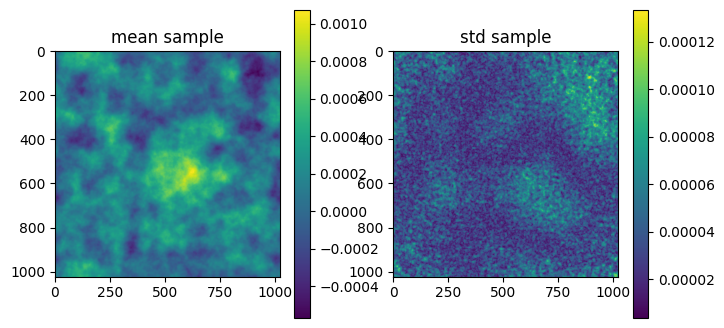

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+1.3861e+08 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+2.6766e+07 Δ⛰:1.1185e+08 ➽:1.0486e+01
SL: Iteration 2 ⛰:+1.4205e+07 Δ⛰:1.2561e+07 ➽:1.0486e+01
SL: Iteration 3 ⛰:+1.2364e+07 Δ⛰:1.8410e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:+7.9588e+06 Δ⛰:4.4052e+06 ➽:1.0486e+01
SL: Iteration 5 ⛰:+6.4243e+06 Δ⛰:1.5345e+06 ➽:1.0486e+01
SL: Iteration 6 ⛰:+5.8859e+06 Δ⛰:5.3841e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:+4.0947e+06 Δ⛰:1.7912e+06 ➽:1.0486e+01
SL: Iteration 8 ⛰:+3.8700e+06 Δ⛰:2.2477e+05 ➽:1.0486e+01
SL: Iteration 9 ⛰:+3.4695e+06 Δ⛰:4.0047e+05 ➽:1.0486e+01
SL: Iteration 10 ⛰:+2.7267e+06 Δ⛰:7.4284e+05 ➽:1.0486e+01
SL: Iteration 11 ⛰:+2.2481e+06 Δ⛰:4.7859e+05 ➽:1.0486e+01
SL: Iteration 12 ⛰:+2.0951e+06 Δ⛰:1.5296e+05 ➽:1.0486e+01
SL: Iteration 13 ⛰:+1.7318e+06 Δ⛰:3.6327e+05 ➽:1.0486e+01
SL: Iteration 14 ⛰:+1.5146e+06 Δ⛰:2.1723e+05 ➽:1.0486e+01
SL: Iteration 15 ⛰:+1.2783e+06 Δ⛰:2.3636e+05 ➽:1.0486e+01
SL: Iteration 16 ⛰:+1.0676e+06 Δ⛰:2.1069e+05 ➽:1.0486e+01
SL: 

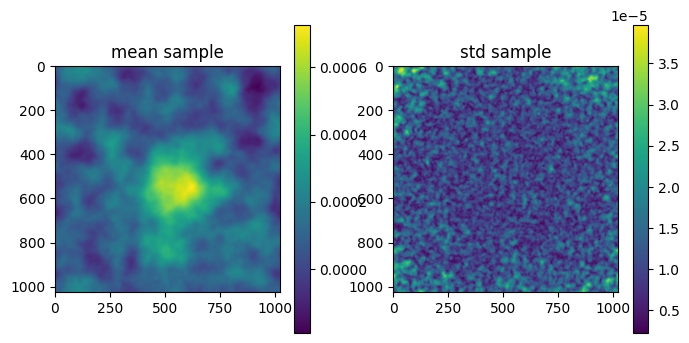

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+1.1269e+08 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+2.9777e+07 Δ⛰:8.2916e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+1.0043e+07 Δ⛰:1.9734e+07 ➽:1.0486e+01
SL: Iteration 3 ⛰:+6.4047e+06 Δ⛰:3.6382e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:+3.5069e+06 Δ⛰:2.8978e+06 ➽:1.0486e+01
SL: Iteration 5 ⛰:+2.0950e+06 Δ⛰:1.4119e+06 ➽:1.0486e+01
SL: Iteration 6 ⛰:+1.8766e+06 Δ⛰:2.1836e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:+1.6568e+06 Δ⛰:2.1979e+05 ➽:1.0486e+01
SL: Iteration 8 ⛰:+9.9260e+05 Δ⛰:6.6424e+05 ➽:1.0486e+01
SL: Iteration 9 ⛰:+8.6455e+05 Δ⛰:1.2806e+05 ➽:1.0486e+01
SL: Iteration 10 ⛰:+4.9532e+05 Δ⛰:3.6923e+05 ➽:1.0486e+01
SL: Iteration 11 ⛰:+3.8699e+05 Δ⛰:1.0833e+05 ➽:1.0486e+01
SL: Iteration 12 ⛰:+2.1765e+05 Δ⛰:1.6933e+05 ➽:1.0486e+01
SL: Iteration 13 ⛰:+7.8439e+04 Δ⛰:1.3921e+05 ➽:1.0486e+01
SL: Iteration 14 ⛰:-3.5186e+04 Δ⛰:1.1362e+05 ➽:1.0486e+01
SL: Iteration 15 ⛰:-8.9041e+04 Δ⛰:5.3855e+04 ➽:1.0486e+01
SL: Iteration 16 ⛰:-1.3709e+05 Δ⛰:4.8047e+04 ➽:1.0486e+01
SL: 

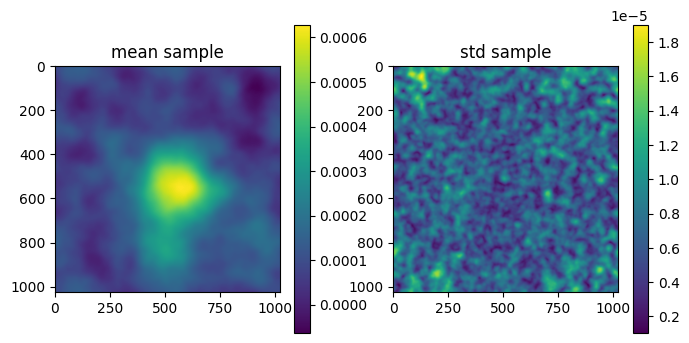

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+8.3184e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+8.5655e+06 Δ⛰:7.4618e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+5.5217e+06 Δ⛰:3.0438e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:+1.4386e+06 Δ⛰:4.0832e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:+9.8685e+05 Δ⛰:4.5170e+05 ➽:1.0486e+01
SL: Iteration 5 ⛰:+8.2040e+05 Δ⛰:1.6645e+05 ➽:1.0486e+01
SL: Iteration 6 ⛰:+1.9551e+05 Δ⛰:6.2489e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:+1.8323e+05 Δ⛰:1.2281e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:+2.1556e+04 Δ⛰:1.6167e+05 ➽:1.0486e+01
SL: Iteration 9 ⛰:-5.9256e+04 Δ⛰:8.0813e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-1.4722e+05 Δ⛰:8.7959e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-3.1504e+05 Δ⛰:1.6782e+05 ➽:1.0486e+01
SL: Iteration 12 ⛰:-3.2249e+05 Δ⛰:7.4485e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-3.4872e+05 Δ⛰:2.6232e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-3.6723e+05 Δ⛰:1.8515e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.0751e+05 Δ⛰:4.0274e+04 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.1017e+05 Δ⛰:2.6662e+03 ➽:1.0486e+01
SL: 

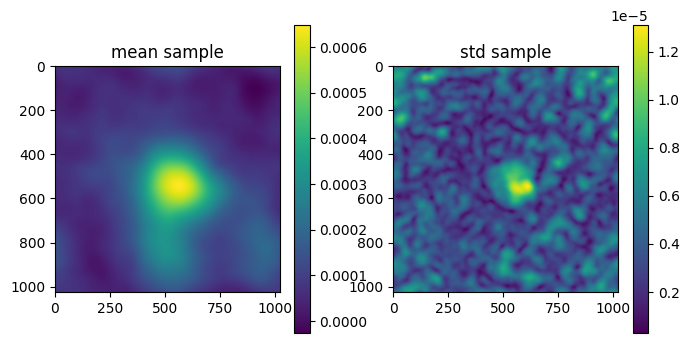

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+7.7325e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+1.0754e+07 Δ⛰:6.6571e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+4.0712e+06 Δ⛰:6.6828e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:+2.3602e+06 Δ⛰:1.7110e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:+1.2307e+06 Δ⛰:1.1295e+06 ➽:1.0486e+01
SL: Iteration 5 ⛰:+1.0477e+06 Δ⛰:1.8301e+05 ➽:1.0486e+01
SL: Iteration 6 ⛰:+4.1095e+05 Δ⛰:6.3677e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:+3.6986e+05 Δ⛰:4.1091e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-6.5958e+04 Δ⛰:4.3581e+05 ➽:1.0486e+01
SL: Iteration 9 ⛰:-1.1509e+05 Δ⛰:4.9129e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-2.9780e+05 Δ⛰:1.8272e+05 ➽:1.0486e+01
SL: Iteration 11 ⛰:-3.0472e+05 Δ⛰:6.9174e+03 ➽:1.0486e+01
SL: Iteration 12 ⛰:-3.7870e+05 Δ⛰:7.3981e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.5075e+05 Δ⛰:7.2047e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.7770e+05 Δ⛰:2.6954e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.7851e+05 Δ⛰:8.1316e+02 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.7867e+05 Δ⛰:1.5391e+02 ➽:1.0486e+01
SL: 

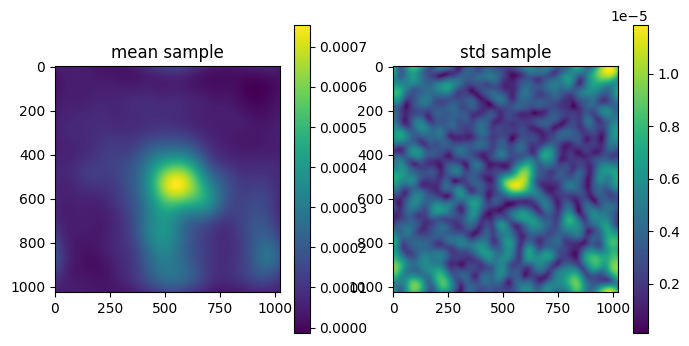

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+4.1958e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+4.3468e+06 Δ⛰:3.7611e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+1.3693e+06 Δ⛰:2.9774e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:+2.6444e+05 Δ⛰:1.1049e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:+2.5329e+05 Δ⛰:1.1143e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-3.0589e+04 Δ⛰:2.8388e+05 ➽:1.0486e+01
SL: Iteration 6 ⛰:-2.0425e+05 Δ⛰:1.7366e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:-2.1696e+05 Δ⛰:1.2713e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.5995e+05 Δ⛰:1.4299e+05 ➽:1.0486e+01
SL: Iteration 9 ⛰:-3.7309e+05 Δ⛰:1.3147e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.3036e+05 Δ⛰:5.7263e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.3791e+05 Δ⛰:7.5540e+03 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.6002e+05 Δ⛰:2.2110e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.7555e+05 Δ⛰:1.5524e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.7565e+05 Δ⛰:1.0823e+02 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.9049e+05 Δ⛰:1.4839e+04 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.9153e+05 Δ⛰:1.0342e+03 ➽:1.0486e+01
SL: 

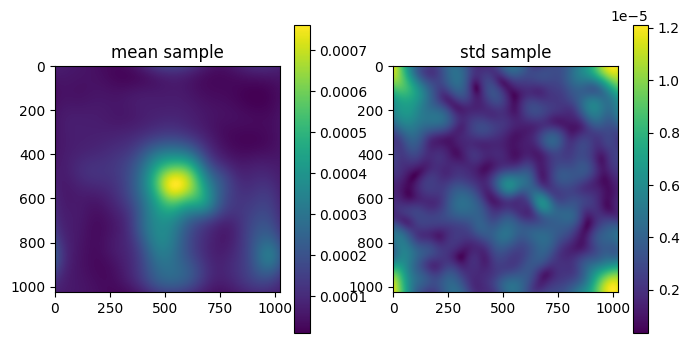

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+1.6678e+08 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+2.4739e+06 Δ⛰:1.6431e+08 ➽:1.0486e+01
SL: Iteration 2 ⛰:+2.1785e+06 Δ⛰:2.9544e+05 ➽:1.0486e+01
SL: Iteration 3 ⛰:-3.4351e+05 Δ⛰:2.5220e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:-3.4684e+05 Δ⛰:3.3369e+03 ➽:1.0486e+01
SL: Iteration 5 ⛰:-3.8489e+05 Δ⛰:3.8050e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-3.8526e+05 Δ⛰:3.6610e+02 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.9942e+05 Δ⛰:1.4156e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-4.4341e+05 Δ⛰:4.3995e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.5052e+05 Δ⛰:7.1117e+03 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.9174e+05 Δ⛰:4.1214e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.9524e+05 Δ⛰:3.5006e+03 ➽:1.0486e+01
SL: Iteration 12 ⛰:-5.0912e+05 Δ⛰:1.3882e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-5.1000e+05 Δ⛰:8.7759e+02 ➽:1.0486e+01
SL: Iteration 14 ⛰:-5.1001e+05 Δ⛰:1.2658e+01 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.1290e+05 Δ⛰:2.8939e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.1291e+05 Δ⛰:1.1915e+01 ➽:1.0486e+01
SL: 

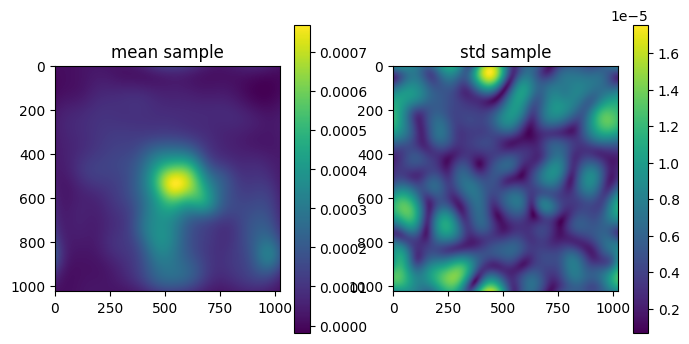

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+2.5601e+08 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+3.9136e+06 Δ⛰:2.5210e+08 ➽:1.0486e+01
SL: Iteration 2 ⛰:+3.2130e+06 Δ⛰:7.0068e+05 ➽:1.0486e+01
SL: Iteration 3 ⛰:-1.4785e+05 Δ⛰:3.3608e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:-1.7068e+05 Δ⛰:2.2833e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-2.1143e+05 Δ⛰:4.0748e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-2.3193e+05 Δ⛰:2.0503e+04 ➽:1.0486e+01
SL: Iteration 7 ⛰:-2.6526e+05 Δ⛰:3.3322e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.8384e+05 Δ⛰:1.1858e+05 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.3671e+05 Δ⛰:5.2872e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.6679e+05 Δ⛰:3.0080e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.6969e+05 Δ⛰:2.9048e+03 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.9401e+05 Δ⛰:2.4312e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.9402e+05 Δ⛰:1.6736e+01 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.9485e+05 Δ⛰:8.3203e+02 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.0090e+05 Δ⛰:6.0498e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.0091e+05 Δ⛰:6.1543e+00 ➽:1.0486e+01
SL: 

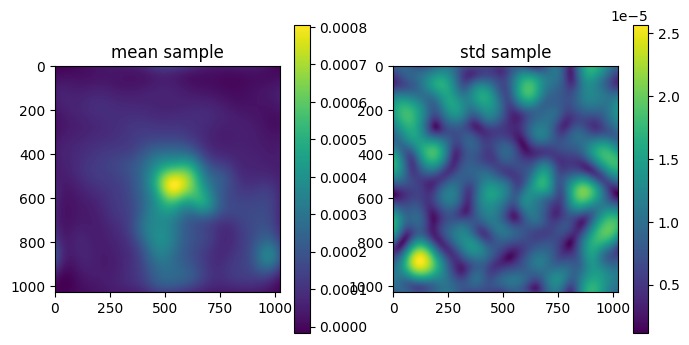

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+5.9442e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+3.5718e+06 Δ⛰:5.5870e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+2.9324e+06 Δ⛰:6.3943e+05 ➽:1.0486e+01
SL: Iteration 3 ⛰:-2.0394e+05 Δ⛰:3.1363e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:-2.0913e+05 Δ⛰:5.1961e+03 ➽:1.0486e+01
SL: Iteration 5 ⛰:-2.6236e+05 Δ⛰:5.3226e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-2.6820e+05 Δ⛰:5.8374e+03 ➽:1.0486e+01
SL: Iteration 7 ⛰:-4.2178e+05 Δ⛰:1.5359e+05 ➽:1.0486e+01
SL: Iteration 8 ⛰:-4.4210e+05 Δ⛰:2.0313e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.7644e+05 Δ⛰:3.4345e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.9442e+05 Δ⛰:1.7983e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-5.0750e+05 Δ⛰:1.3075e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-5.1330e+05 Δ⛰:5.8045e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-5.1474e+05 Δ⛰:1.4347e+03 ➽:1.0486e+01
SL: Iteration 14 ⛰:-5.1497e+05 Δ⛰:2.3702e+02 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.1498e+05 Δ⛰:3.9774e+00 ➽:1.0486e+01
SL: Iteration 0 ⛰:+3.0970e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteratio

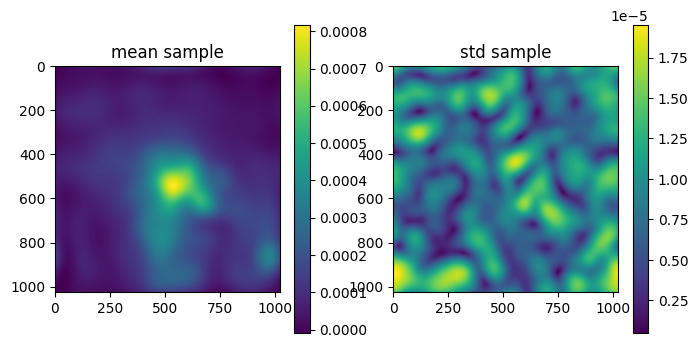

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+4.7458e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+8.5509e+06 Δ⛰:3.8907e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+4.9263e+06 Δ⛰:3.6247e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:-2.0470e+05 Δ⛰:5.1310e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:-3.0383e+05 Δ⛰:9.9127e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-3.1335e+05 Δ⛰:9.5154e+03 ➽:1.0486e+01
SL: Iteration 6 ⛰:-3.6654e+05 Δ⛰:5.3196e+04 ➽:1.0486e+01
SL: Iteration 7 ⛰:-4.1544e+05 Δ⛰:4.8902e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-4.4952e+05 Δ⛰:3.4076e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.6846e+05 Δ⛰:1.8945e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.8969e+05 Δ⛰:2.1224e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.9540e+05 Δ⛰:5.7162e+03 ➽:1.0486e+01
SL: Iteration 12 ⛰:-5.0056e+05 Δ⛰:5.1587e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-5.0706e+05 Δ⛰:6.4971e+03 ➽:1.0486e+01
SL: Iteration 14 ⛰:-5.1177e+05 Δ⛰:4.7122e+03 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.1544e+05 Δ⛰:3.6648e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.1546e+05 Δ⛰:2.0989e+01 ➽:1.0486e+01
SL: 

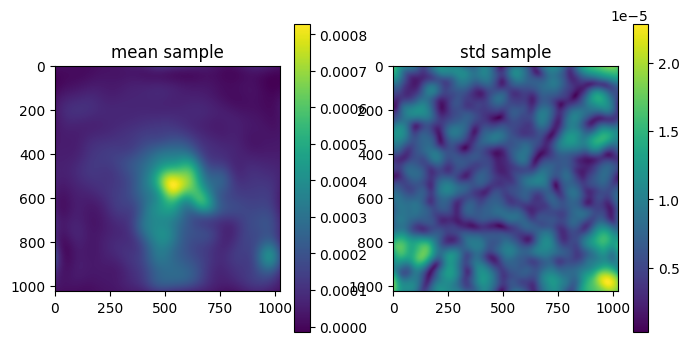

OPTIMIZE_KL: Starting 0011
SL: Iteration 0 ⛰:+5.1115e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+5.0485e+06 Δ⛰:4.6066e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+2.8081e+06 Δ⛰:2.2404e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:-3.1083e+05 Δ⛰:3.1189e+06 ➽:1.0486e+01
SL: Iteration 4 ⛰:-3.8466e+05 Δ⛰:7.3831e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-3.8748e+05 Δ⛰:2.8197e+03 ➽:1.0486e+01
SL: Iteration 6 ⛰:-4.1593e+05 Δ⛰:2.8450e+04 ➽:1.0486e+01
SL: Iteration 7 ⛰:-4.6294e+05 Δ⛰:4.7000e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-4.6803e+05 Δ⛰:5.0991e+03 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.8425e+05 Δ⛰:1.6220e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.9263e+05 Δ⛰:8.3723e+03 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.9915e+05 Δ⛰:6.5259e+03 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.9961e+05 Δ⛰:4.6183e+02 ➽:1.0486e+01
SL: Iteration 13 ⛰:-5.0416e+05 Δ⛰:4.5458e+03 ➽:1.0486e+01
SL: Iteration 14 ⛰:-5.1043e+05 Δ⛰:6.2730e+03 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.1379e+05 Δ⛰:3.3598e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.1381e+05 Δ⛰:1.8752e+01 ➽:1.0486e+01
SL: 

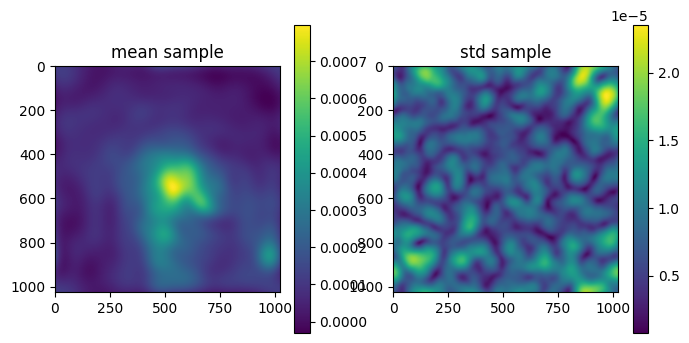

OPTIMIZE_KL: Starting 0012
SL: Iteration 0 ⛰:+4.4095e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+2.9205e+06 Δ⛰:4.1175e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+1.4629e+06 Δ⛰:1.4575e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:+8.7659e+05 Δ⛰:5.8633e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:+4.9024e+04 Δ⛰:8.2757e+05 ➽:1.0486e+01
SL: Iteration 5 ⛰:+3.1723e+04 Δ⛰:1.7301e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-1.2739e+05 Δ⛰:1.5911e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:-2.9025e+05 Δ⛰:1.6286e+05 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.1819e+05 Δ⛰:2.7939e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-3.5143e+05 Δ⛰:3.3242e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.2356e+05 Δ⛰:7.2126e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.5076e+05 Δ⛰:2.7201e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.5404e+05 Δ⛰:3.2800e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.8358e+05 Δ⛰:2.9540e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-5.0386e+05 Δ⛰:2.0277e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.0414e+05 Δ⛰:2.8275e+02 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.0827e+05 Δ⛰:4.1305e+03 ➽:1.0486e+01
SL: 

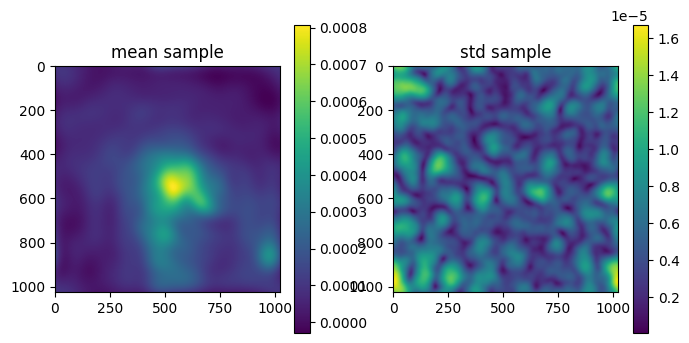

OPTIMIZE_KL: Starting 0013
SL: Iteration 0 ⛰:+2.6180e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+3.1397e+06 Δ⛰:2.3040e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+1.1160e+06 Δ⛰:2.0237e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:+3.1352e+05 Δ⛰:8.0250e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:+1.2789e+04 Δ⛰:3.0074e+05 ➽:1.0486e+01
SL: Iteration 5 ⛰:-2.3269e+04 Δ⛰:3.6058e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-2.8615e+05 Δ⛰:2.6289e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.0020e+05 Δ⛰:1.4049e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.5687e+05 Δ⛰:5.6663e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-3.8546e+05 Δ⛰:2.8590e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.5977e+05 Δ⛰:7.4313e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.7685e+05 Δ⛰:1.7078e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.7825e+05 Δ⛰:1.4004e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.9066e+05 Δ⛰:1.2413e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-5.0004e+05 Δ⛰:9.3817e+03 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.0019e+05 Δ⛰:1.4554e+02 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.0505e+05 Δ⛰:4.8668e+03 ➽:1.0486e+01
SL: 

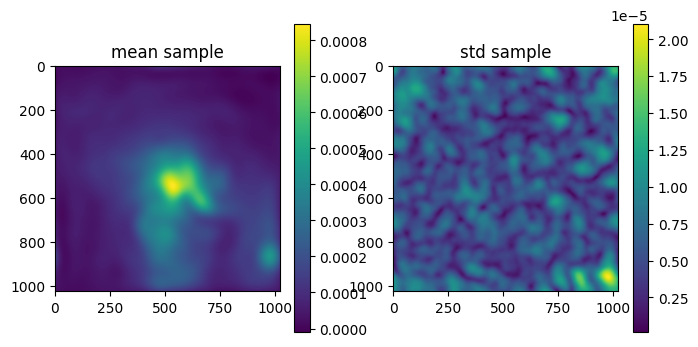

OPTIMIZE_KL: Starting 0014
SL: Iteration 0 ⛰:+1.9250e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+3.0598e+06 Δ⛰:1.6190e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+6.6024e+05 Δ⛰:2.3996e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:-1.6794e+05 Δ⛰:8.2818e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:-2.9564e+05 Δ⛰:1.2770e+05 ➽:1.0486e+01
SL: Iteration 5 ⛰:-3.0594e+05 Δ⛰:1.0299e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-3.6936e+05 Δ⛰:6.3417e+04 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.7886e+05 Δ⛰:9.5069e+03 ➽:1.0486e+01
SL: Iteration 8 ⛰:-4.0428e+05 Δ⛰:2.5418e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.2816e+05 Δ⛰:2.3873e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.6350e+05 Δ⛰:3.5350e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.7442e+05 Δ⛰:1.0913e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.7675e+05 Δ⛰:2.3290e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.9947e+05 Δ⛰:2.2728e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-5.0627e+05 Δ⛰:6.7934e+03 ➽:1.0486e+01
SL: Iteration 15 ⛰:-5.0695e+05 Δ⛰:6.8383e+02 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.0792e+05 Δ⛰:9.6422e+02 ➽:1.0486e+01
SL: 

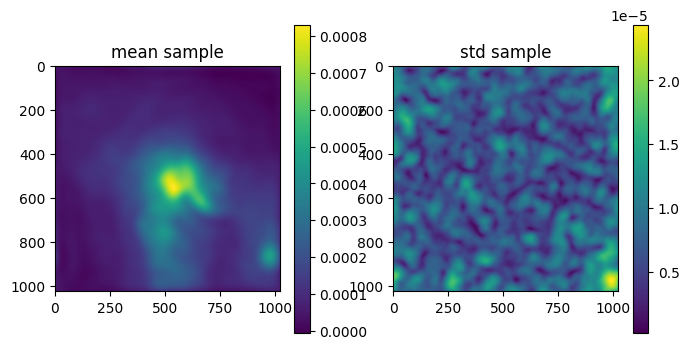

OPTIMIZE_KL: Starting 0015
SL: Iteration 0 ⛰:+6.0300e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+1.7739e+06 Δ⛰:5.8526e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+7.8242e+05 Δ⛰:9.9152e+05 ➽:1.0486e+01
SL: Iteration 3 ⛰:-5.6956e+04 Δ⛰:8.3938e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:-1.4592e+05 Δ⛰:8.8964e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-1.6320e+05 Δ⛰:1.7282e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-3.5624e+05 Δ⛰:1.9303e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.6876e+05 Δ⛰:1.2524e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-4.0295e+05 Δ⛰:3.4188e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.1773e+05 Δ⛰:1.4783e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.4736e+05 Δ⛰:2.9627e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.6599e+05 Δ⛰:1.8635e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.6997e+05 Δ⛰:3.9758e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.7900e+05 Δ⛰:9.0334e+03 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.9348e+05 Δ⛰:1.4477e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.9794e+05 Δ⛰:4.4623e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.9802e+05 Δ⛰:8.2585e+01 ➽:1.0486e+01
SL: 

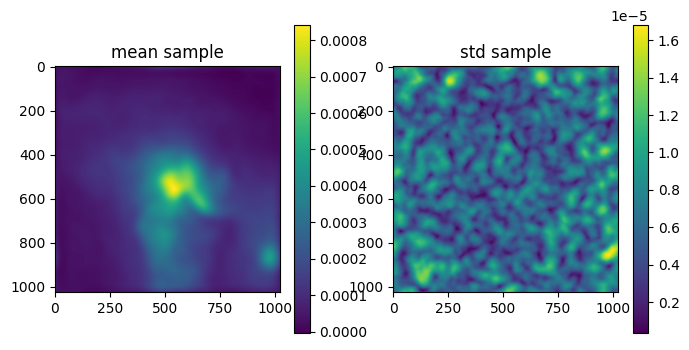

OPTIMIZE_KL: Starting 0016
SL: Iteration 0 ⛰:+1.5009e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+1.3752e+06 Δ⛰:1.3634e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+4.3703e+05 Δ⛰:9.3812e+05 ➽:1.0486e+01
SL: Iteration 3 ⛰:-1.4388e+05 Δ⛰:5.8091e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:-1.7516e+05 Δ⛰:3.1282e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-2.2745e+05 Δ⛰:5.2285e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-3.1394e+05 Δ⛰:8.6491e+04 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.3862e+05 Δ⛰:2.4684e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.6558e+05 Δ⛰:2.6957e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-3.8688e+05 Δ⛰:2.1298e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.1734e+05 Δ⛰:3.0462e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.3976e+05 Δ⛰:2.2423e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.5631e+05 Δ⛰:1.6548e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.7550e+05 Δ⛰:1.9191e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.8614e+05 Δ⛰:1.0636e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.8971e+05 Δ⛰:3.5748e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.8980e+05 Δ⛰:8.8494e+01 ➽:1.0486e+01
SL: 

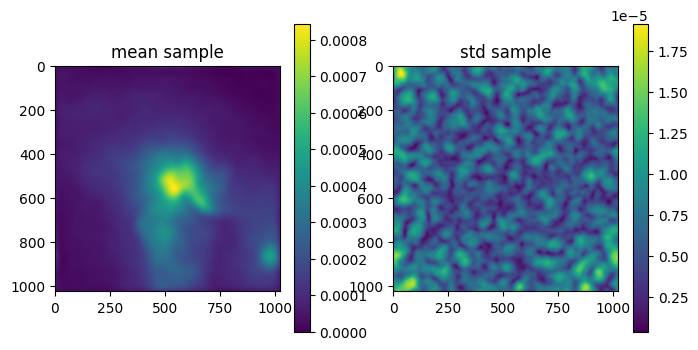

OPTIMIZE_KL: Starting 0017
SL: Iteration 0 ⛰:+2.2014e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+2.3152e+06 Δ⛰:1.9698e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+8.3287e+05 Δ⛰:1.4823e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:+2.6611e+05 Δ⛰:5.6676e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:+6.2368e+04 Δ⛰:2.0374e+05 ➽:1.0486e+01
SL: Iteration 5 ⛰:+1.0829e+04 Δ⛰:5.1539e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-2.2760e+05 Δ⛰:2.3843e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:-2.8155e+05 Δ⛰:5.3946e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.2847e+05 Δ⛰:4.6924e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-3.9844e+05 Δ⛰:6.9972e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.2894e+05 Δ⛰:3.0498e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.5337e+05 Δ⛰:2.4428e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.5996e+05 Δ⛰:6.5915e+03 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.7986e+05 Δ⛰:1.9897e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.9039e+05 Δ⛰:1.0529e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.9447e+05 Δ⛰:4.0839e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.9483e+05 Δ⛰:3.6211e+02 ➽:1.0486e+01
SL: 

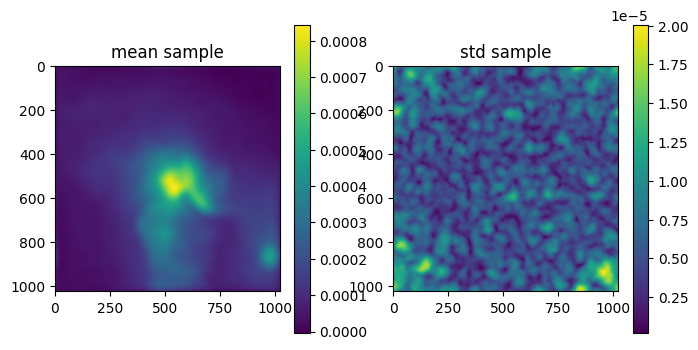

OPTIMIZE_KL: Starting 0018
SL: Iteration 0 ⛰:+1.7801e+06 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+8.8873e+05 Δ⛰:8.9135e+05 ➽:1.0486e+01
SL: Iteration 2 ⛰:+6.5608e+04 Δ⛰:8.2312e+05 ➽:1.0486e+01
SL: Iteration 3 ⛰:+9.2027e+03 Δ⛰:5.6406e+04 ➽:1.0486e+01
SL: Iteration 4 ⛰:-8.4029e+04 Δ⛰:9.3232e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-1.4588e+05 Δ⛰:6.1854e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-2.8233e+05 Δ⛰:1.3645e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.6577e+05 Δ⛰:8.3434e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.7045e+05 Δ⛰:4.6853e+03 ➽:1.0486e+01
SL: Iteration 9 ⛰:-3.9082e+05 Δ⛰:2.0370e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.2703e+05 Δ⛰:3.6208e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.4329e+05 Δ⛰:1.6264e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.6101e+05 Δ⛰:1.7711e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.7930e+05 Δ⛰:1.8298e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.8959e+05 Δ⛰:1.0287e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.9411e+05 Δ⛰:4.5142e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-5.0152e+05 Δ⛰:7.4117e+03 ➽:1.0486e+01
SL: 

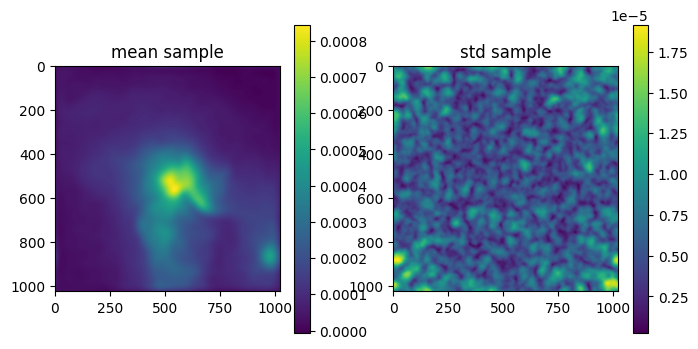

OPTIMIZE_KL: Starting 0019
SL: Iteration 0 ⛰:+1.4317e+07 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+1.8699e+06 Δ⛰:1.2447e+07 ➽:1.0486e+01
SL: Iteration 2 ⛰:+2.7004e+05 Δ⛰:1.5999e+06 ➽:1.0486e+01
SL: Iteration 3 ⛰:-1.0228e+05 Δ⛰:3.7232e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:-1.9200e+05 Δ⛰:8.9715e+04 ➽:1.0486e+01
SL: Iteration 5 ⛰:-2.4766e+05 Δ⛰:5.5665e+04 ➽:1.0486e+01
SL: Iteration 6 ⛰:-3.4769e+05 Δ⛰:1.0003e+05 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.7500e+05 Δ⛰:2.7311e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.9822e+05 Δ⛰:2.3221e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-4.1125e+05 Δ⛰:1.3027e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-4.3543e+05 Δ⛰:2.4184e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.4527e+05 Δ⛰:9.8400e+03 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.6532e+05 Δ⛰:2.0042e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.7160e+05 Δ⛰:6.2833e+03 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.8033e+05 Δ⛰:8.7278e+03 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.8790e+05 Δ⛰:7.5753e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.9167e+05 Δ⛰:3.7626e+03 ➽:1.0486e+01
SL: 

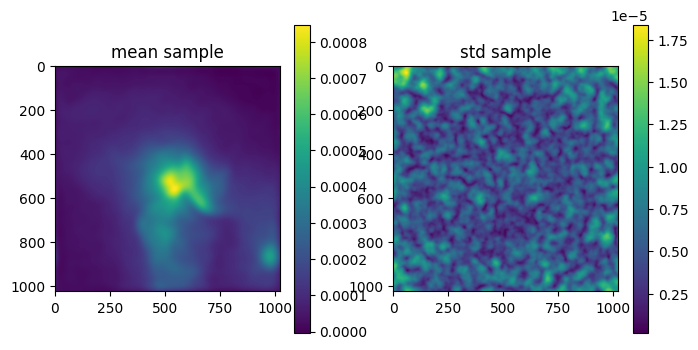

OPTIMIZE_KL: Starting 0020
SL: Iteration 0 ⛰:+6.4586e+06 Δ⛰:inf ➽:1.0486e+01
SL: Iteration 1 ⛰:+1.6178e+06 Δ⛰:4.8408e+06 ➽:1.0486e+01
SL: Iteration 2 ⛰:+7.3450e+05 Δ⛰:8.8332e+05 ➽:1.0486e+01
SL: Iteration 3 ⛰:+4.1692e+05 Δ⛰:3.1758e+05 ➽:1.0486e+01
SL: Iteration 4 ⛰:+5.0785e+04 Δ⛰:3.6613e+05 ➽:1.0486e+01
SL: Iteration 5 ⛰:-1.5559e+05 Δ⛰:2.0638e+05 ➽:1.0486e+01
SL: Iteration 6 ⛰:-2.5286e+05 Δ⛰:9.7268e+04 ➽:1.0486e+01
SL: Iteration 7 ⛰:-3.1295e+05 Δ⛰:6.0086e+04 ➽:1.0486e+01
SL: Iteration 8 ⛰:-3.3350e+05 Δ⛰:2.0554e+04 ➽:1.0486e+01
SL: Iteration 9 ⛰:-3.6188e+05 Δ⛰:2.8380e+04 ➽:1.0486e+01
SL: Iteration 10 ⛰:-3.7865e+05 Δ⛰:1.6768e+04 ➽:1.0486e+01
SL: Iteration 11 ⛰:-4.1425e+05 Δ⛰:3.5604e+04 ➽:1.0486e+01
SL: Iteration 12 ⛰:-4.4133e+05 Δ⛰:2.7076e+04 ➽:1.0486e+01
SL: Iteration 13 ⛰:-4.6597e+05 Δ⛰:2.4642e+04 ➽:1.0486e+01
SL: Iteration 14 ⛰:-4.7809e+05 Δ⛰:1.2118e+04 ➽:1.0486e+01
SL: Iteration 15 ⛰:-4.8383e+05 Δ⛰:5.7389e+03 ➽:1.0486e+01
SL: Iteration 16 ⛰:-4.9029e+05 Δ⛰:6.4627e+03 ➽:1.0486e+01
SL: 

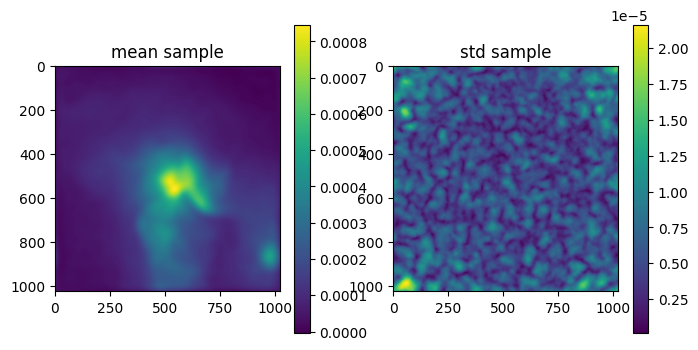

In [21]:
# n_it = 4
n_it = 20
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-12
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)

    im1 = axes[1].imshow(std)
    axes[1].title.set_text('std sample')
    fig.colorbar(im1)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=20),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    callback=callback,
)

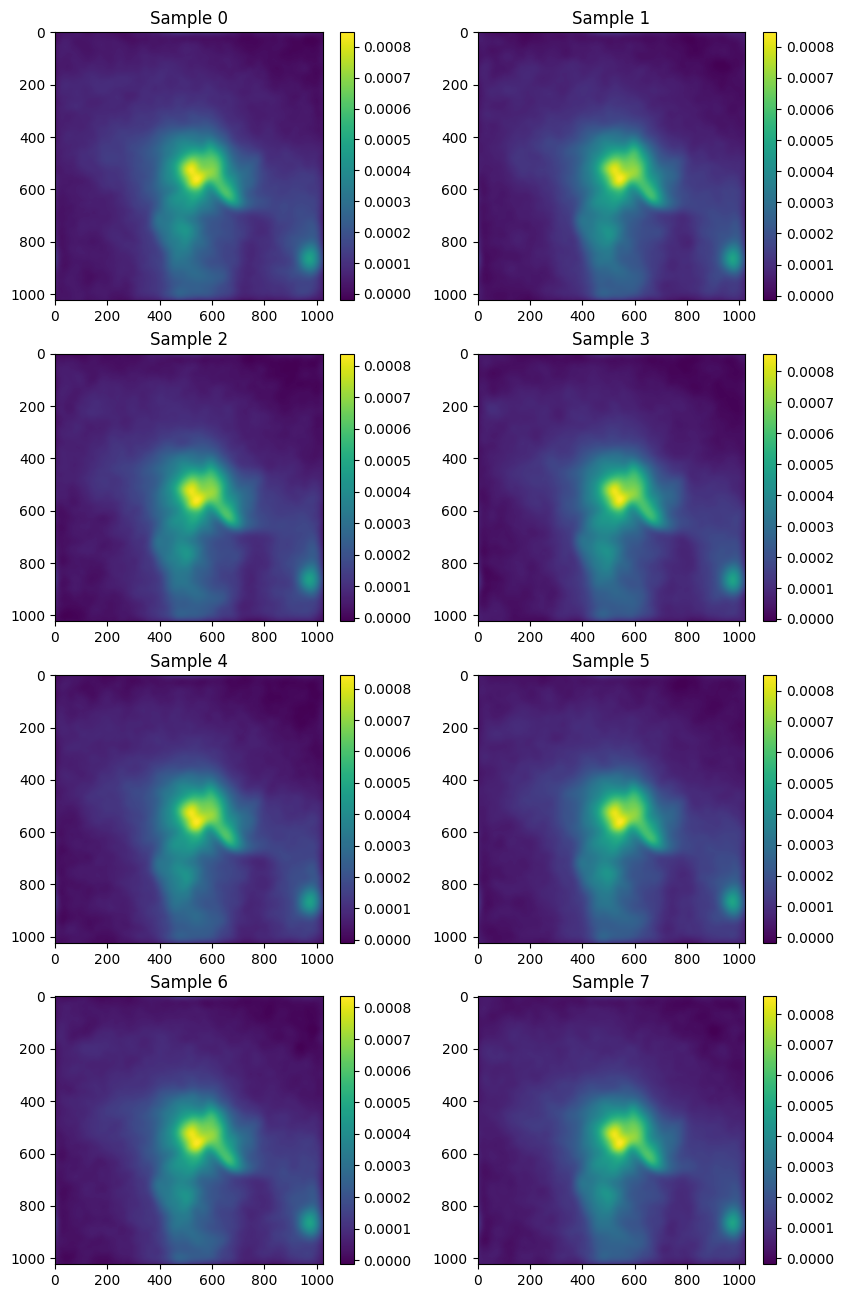

In [22]:
# plot all samples
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    # im = axes[i//4][i%4].imshow(signal_response(s))
    im = axes[i//2][i%2].imshow(gp_map(s))
    axes[i//2][i%2].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()

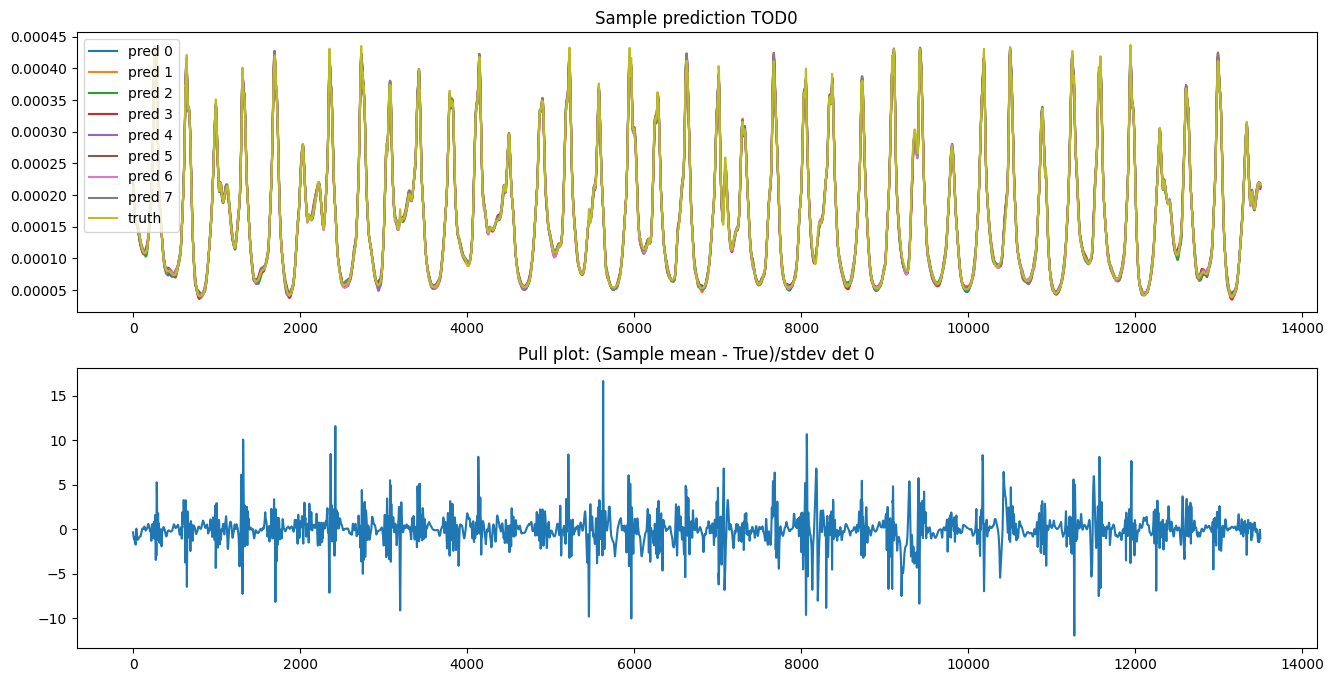

In [23]:
# plot time-series for det 0 for all samples:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

i = 0
for s in samples:

    axes[0].plot(signal_response_tod(s)[0], label=f"pred {i}")
    # axes[1].plot((signal_response_tod(s)[0] - jax_tods[0])/std[0], label=i)
    i += 1

axes[0].plot(jax_tods[0], label="truth")
axes[0].set_title("Sample prediction TOD0")
axes[0].legend()

# axes[1].plot(jax_tods[0])
axes[1].plot((mean[0] - jax_tods[0])/std[0])
axes[1].set_title(f"Pull plot: (Sample mean - True)/stdev det 0")
# axes[1].legend()

plt.show()

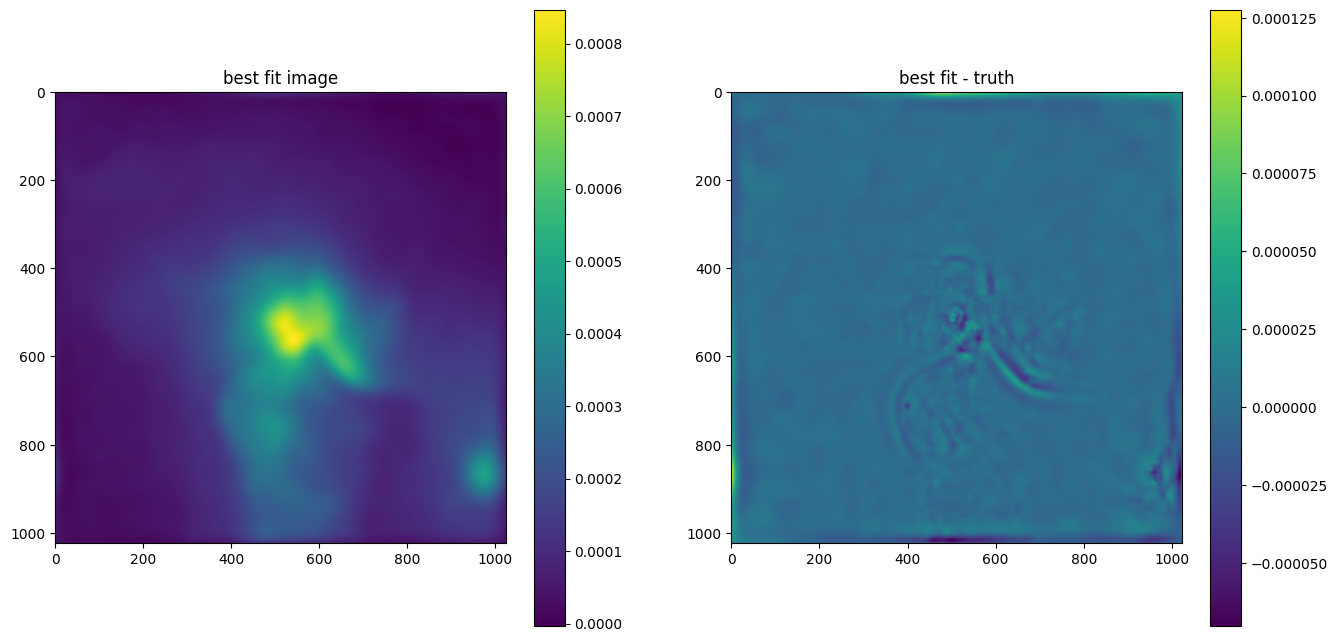

In [24]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0])
axes[1].title.set_text('best fit - truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

In [29]:
# Compare with maria mapper:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(300.0, -10.0),
                   frame="ra_dec",
                   width=1.,
                   height=1.,
                   resolution=np.degrees(np.nanmin(instrument.fwhm))/4.,
                   tod_postprocessing={
                        "window": {"tukey": {"alpha": 0.1}},
                        "remove_modes": {"n": 1},
                        "highpass": {"f": 0.05},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod_truthmap)
output_map = mapper.run()

Running mapper (f092): 100%|██████████| 1/1 [01:55<00:00, 115.79s/it]


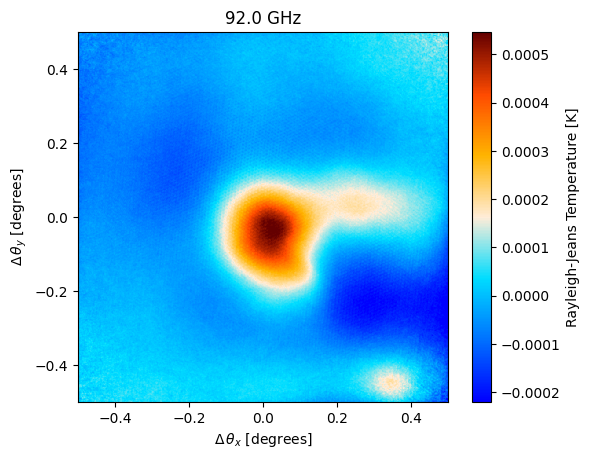

In [30]:
output_map.plot()

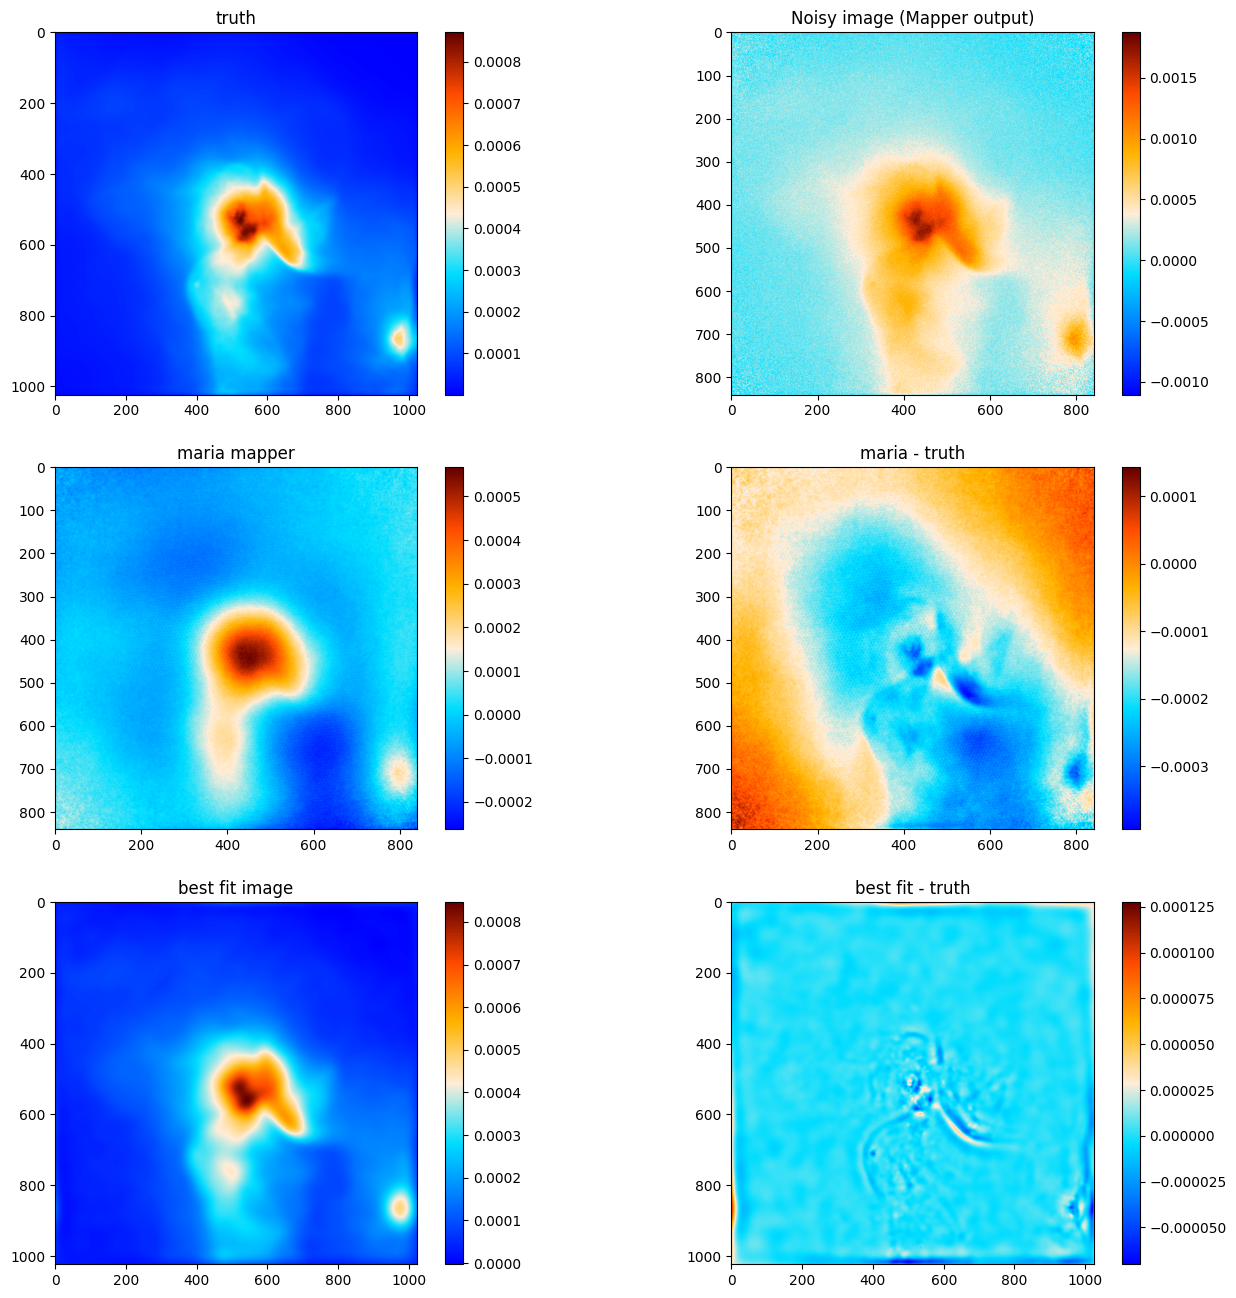

In [32]:
from skimage.transform import resize

# Compare nifty vs maria
sig_map = gp_map(samples.pos) # when splitting up in different field models
# mincol = -0.0012
# maxcol = 0.
# mincol = -0.7e-4
# maxcol = 2e-3
mincol = None
maxcol = None

cmb_cmap = plt.get_cmap('cmb')
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

im0 = axes[0,0].imshow( mapdata_truth[0] , cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[0,0].title.set_text('truth')
fig.colorbar(im0)

im1 = axes[0,1].imshow(output_truthmap.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
fig.colorbar(im1)
axes[0,1].title.set_text("Noisy image (Mapper output)")

im2 = axes[1,0].imshow( output_map.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,0].title.set_text('maria mapper')
fig.colorbar(im2)

truth_rescaled = resize(mapdata_truth[0], (841, 841), anti_aliasing=True)
im3 = axes[1,1].imshow(( output_map.data[0] - truth_rescaled), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,1].title.set_text('maria - truth')
fig.colorbar(im3)

im3 = axes[2,0].imshow(sig_map, cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,0].title.set_text('best fit image')
fig.colorbar(im3)

im4 = axes[2,1].imshow((sig_map - mapdata_truth[0]), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,1].title.set_text('best fit - truth')
fig.colorbar(im4)

plt.show()